# Step 1: Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Import Necessary Libraries

In [2]:
# Importing necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report

# Step 3: Define Paths and Parameters

In [3]:
# Define paths
train_path = '/media/samyog/My Folder/AI and ML/Others/Vehicles/train'
val_path = '/media/samyog/My Folder/AI and ML/Others/Vehicles/val'
test_path = '/media/samyog/My Folder/AI and ML/Others/Vehicles/test'

# Parameters
IMG_SIZE = (128, 128)  # Size of image 
BATCH_SIZE = 64 # Batch size or number of images per batch
EPOCHS = 30 # number of epochs or iterations
NUM_OF_CLASSES = 7  # cab, tank, etc. (7 folders)

# Step 4: Data Preparation and Augmentation

In [4]:
# Data augmentation for training set

# Creating an instance of ImageDataGenerator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest' 
)

# Only rescaling for validation and test sets
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and test sets
train_generator = train_data_gen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_data_gen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_data_gen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names
class_names = list(train_generator.class_indices.keys())

Found 8688 images belonging to 7 classes.
Found 2702 images belonging to 7 classes.
Found 940 images belonging to 7 classes.



Training Set Class Distribution:
cab: 801 images
fire_engine: 1333 images
horse_cart: 1297 images
recreational_vehicle: 1267 images
snowmobile: 1351 images
tank: 1340 images
unicycle: 1299 images


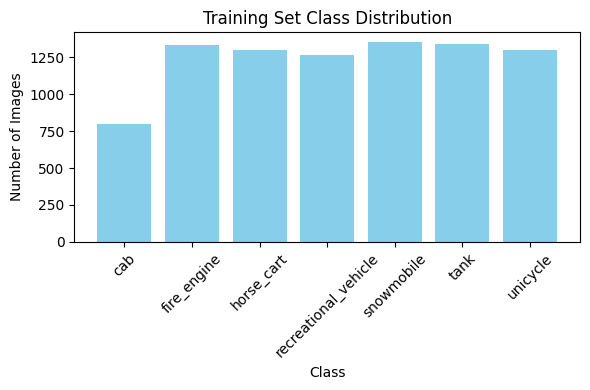


Validation Set Class Distribution:
cab: 388 images
fire_engine: 375 images
horse_cart: 393 images
recreational_vehicle: 405 images
snowmobile: 386 images
tank: 372 images
unicycle: 383 images


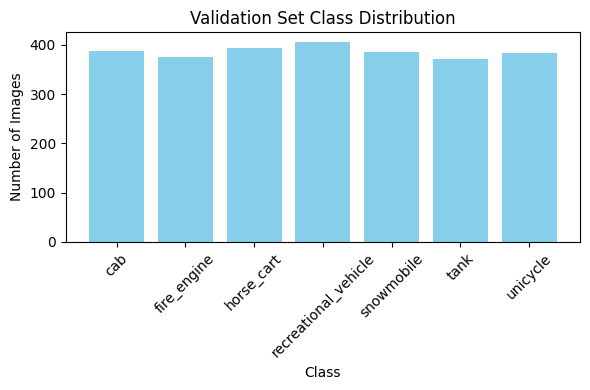


Test Set Class Distribution:
cab: 111 images
fire_engine: 148 images
horse_cart: 134 images
recreational_vehicle: 149 images
snowmobile: 125 images
tank: 129 images
unicycle: 144 images


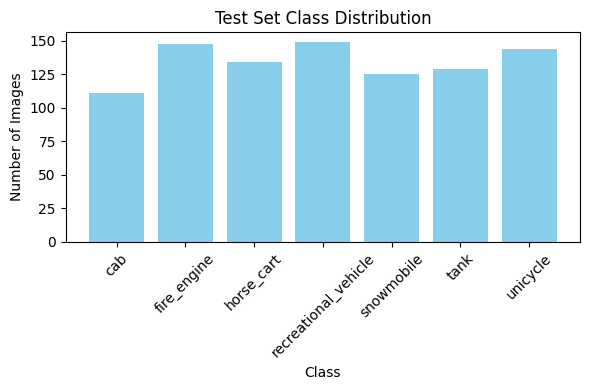

In [5]:
# Function to count class distribution from a generator
def plot_class_distribution(generator, title):
    labels = generator.classes
    class_names = list(generator.class_indices.keys())
    counts = np.bincount(labels)

    print(f"\n{title} Set Class Distribution:")
    for i, count in enumerate(counts):
        print(f"{class_names[i]}: {count} images")

    # Plotting
    plt.figure(figsize=(6,4))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(f'{title} Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Check all sets
plot_class_distribution(train_generator, "Training")
plot_class_distribution(val_generator, "Validation")
plot_class_distribution(test_generator, "Test")

# Baseline CNN Model (Model 1)

In [7]:
# 1. Baseline CNN Model (Simple Architecture)
def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(NUM_OF_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,315,207 (12.65 MB)

 Trainable params: 3,315,207 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
Classification Report:
                      precision    recall  f1-score   support

                 cab       0.00      0.00      0.00       111
         fire_engine       0.12      0.01      0.01       148
          horse_cart       0.00      0.00      0.00       134
recreational_vehicle       0.16      0.91      0.26       149
          snowmobile       0.15      0.07      0.10       125
                tank       0.00      0.00      0.00       129
            unicycle       0.00      0.00      0.00       144

            accuracy                           0.15       940
           macro avg       0.06      0.14      0.05       940
        weighted avg       0.06      0.15      0.06       940



/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

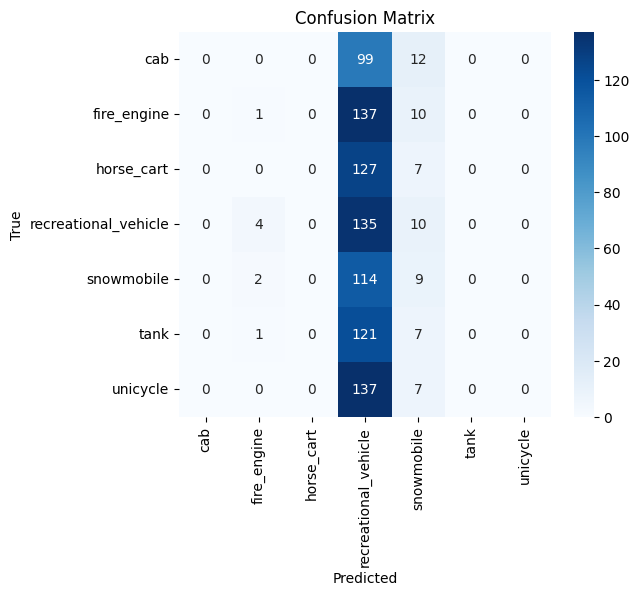

In [9]:
# Evaluating the Baseline CNN Model

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# True labels and predictions
y_true = test_generator.classes
y_pred_probs = baseline_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (binary only)
if len(class_labels) == 2:
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# Step 5: Build CNN Model


In [11]:
# 2. Deeper CNN with BatchNorm, Dropout & Adam
def create_deep_model(optimizer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_OF_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using Adam
deep_model_adam = create_deep_model(Adam(learning_rate=0.0001))
deep_model_adam.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,687 (10.50 MB)

 Trainable params: 2,750,727 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

# Deeper CNN with SGD (Model 2, SGD Variant)

In [14]:
from tensorflow.keras.optimizers import Adam, SGD

# 3. Deeper CNN Again, But With SGD
deep_model_sgd = create_deep_model(SGD(learning_rate=0.01, momentum=0.9))
deep_model_sgd.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,687 (10.50 MB)

 Trainable params: 2,750,727 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

# Step 6: Define Callbacks Function to Train the Model

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import time

def train_model(model, name, use_class_weights=True):
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

    # Compute class weights if enabled
    class_weight = None
    if use_class_weights:
        labels = train_generator.classes
        class_weights_array = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )
        class_weight = dict(enumerate(class_weights_array))
        print("\nUsing class weights:", class_weight)

    # Optional: track training time
    start_time = time.time()

    # Training
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr],
        class_weight=class_weight  
    )

    duration = (time.time() - start_time) / 60
    print(f"\nTraining completed in {duration:.2f} minutes")

    # Save model
    model.save(f'{name}.h5')
    return history


# Step 7: Train All Models

In [17]:
# Train All Models and Collect Histories
history_baseline = train_model(baseline_model, 'baseline_cnn')
history_deep_adam = train_model(deep_model_adam, 'deep_cnn_adam')
history_deep_sgd = train_model(deep_model_sgd, 'deep_cnn_sgd')



Using class weights: {0: np.float64(1.5494917067950775), 1: np.float64(0.9310899153359768), 2: np.float64(0.9569335829937218), 3: np.float64(0.9795918367346939), 4: np.float64(0.9186845722745056), 5: np.float64(0.926226012793177), 6: np.float64(0.9554602441438469)}


/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 135s 984ms/step - accuracy: 0.1668 - loss: 1.9304 - val_accuracy: 0.2961 - val_loss: 1.7913 - learning_rate: 1.0000e-04
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 2:02 915ms/step - accuracy: 0.2969 - loss: 1.7947

/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2969 - loss: 1.7947 - val_accuracy: 0.3125 - val_loss: 1.7775 - learning_rate: 1.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3017 - loss: 1.7780 - val_accuracy: 0.4066 - val_loss: 1.5941 - learning_rate: 1.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.3906 - loss: 1.6654 - val_accuracy: 0.3943 - val_loss: 1.6152 - learning_rate: 1.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.3804 - loss: 1.6249 - val_accuracy: 0.4613 - val_loss: 1.4765 - learning_rate: 1.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.4219 - loss: 1.5277 - val_accuracy: 0.4821 - val_loss: 1.4493 - learning_rate: 1.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.4295 - loss: 1.5131 - val_accuracy: 0.5048 - val_loss: 1.3923 - learning_rate: 1.0000e-04
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy:


Using class weights: {0: np.float64(1.5494917067950775), 1: np.float64(0.9310899153359768), 2: np.float64(0.9569335829937218), 3: np.float64(0.9795918367346939), 4: np.float64(0.9186845722745056), 5: np.float64(0.926226012793177), 6: np.float64(0.9554602441438469)}
Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.2978 - loss: 2.2566 - val_accuracy: 0.1462 - val_loss: 3.2347 - learning_rate: 1.0000e-04
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 10:46 5s/step - accuracy: 0.3125 - loss: 1.6403

/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.3125 - loss: 1.6403 - val_accuracy: 0.1462 - val_loss: 3.2413 - learning_rate: 1.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.4109 - loss: 1.6042 - val_accuracy: 0.2046 - val_loss: 2.5538 - learning_rate: 1.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.3594 - loss: 1.7601 - val_accuracy: 0.2039 - val_loss: 2.5632 - learning_rate: 1.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.4429 - loss: 1.5152 - val_accuracy: 0.4148 - val_loss: 1.5569 - learning_rate: 1.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.4688 - loss: 1.4410 - val_accuracy: 0.4103 - val_loss: 1.5524 - learning_rate: 1.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.4803 - loss: 1.4229 - val_accuracy: 0.5908 - val_loss: 1.2021 - learning_rate: 1.0000e-04
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accura


Training completed in 94.46 minutes

Using class weights: {0: np.float64(1.5494917067950775), 1: np.float64(0.9310899153359768), 2: np.float64(0.9569335829937218), 3: np.float64(0.9795918367346939), 4: np.float64(0.9186845722745056), 5: np.float64(0.926226012793177), 6: np.float64(0.9554602441438469)}
Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.2599 - loss: 2.3188 - val_accuracy: 0.2500 - val_loss: 1.8808 - learning_rate: 0.0100
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.3125 - loss: 1.7283

/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.3125 - loss: 1.7283 - val_accuracy: 0.2556 - val_loss: 1.8741 - learning_rate: 0.0100
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.3464 - loss: 1.7182 - val_accuracy: 0.4100 - val_loss: 1.5937 - learning_rate: 0.0100
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.5938 - loss: 1.3521 - val_accuracy: 0.4055 - val_loss: 1.5957 - learning_rate: 0.0100
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.3646 - loss: 1.6890 - val_accuracy: 0.3824 - val_loss: 1.6229 - learning_rate: 0.0100
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.3125 - loss: 1.5951 - val_accuracy: 0.3821 - val_loss: 1.6112 - learning_rate: 0.0100
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.3967 - loss: 1.6053 - val_accuracy: 0.5439 - val_loss: 1.3192 - learning_rate: 0.0020
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.4688 - loss: 1.498


Training completed in 89.18 minutes


# Step 8: Evaluate Function and Evaluating Model


Evaluating Baseline CNN
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.6302 - loss: 1.1595
Baseline CNN - Test Accuracy: 55.96%
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step
                      precision    recall  f1-score   support

                 cab       0.54      0.61      0.58       111
         fire_engine       0.63      0.74      0.68       148
          horse_cart       0.42      0.63      0.50       134
recreational_vehicle       0.55      0.54      0.55       149
          snowmobile       0.70      0.71      0.71       125
                tank       0.59      0.54      0.56       129
            unicycle       0.51      0.17      0.25       144

            accuracy                           0.56       940
           macro avg       0.56      0.56      0.55       940
        weighted avg       0.56      0.56      0.54       940



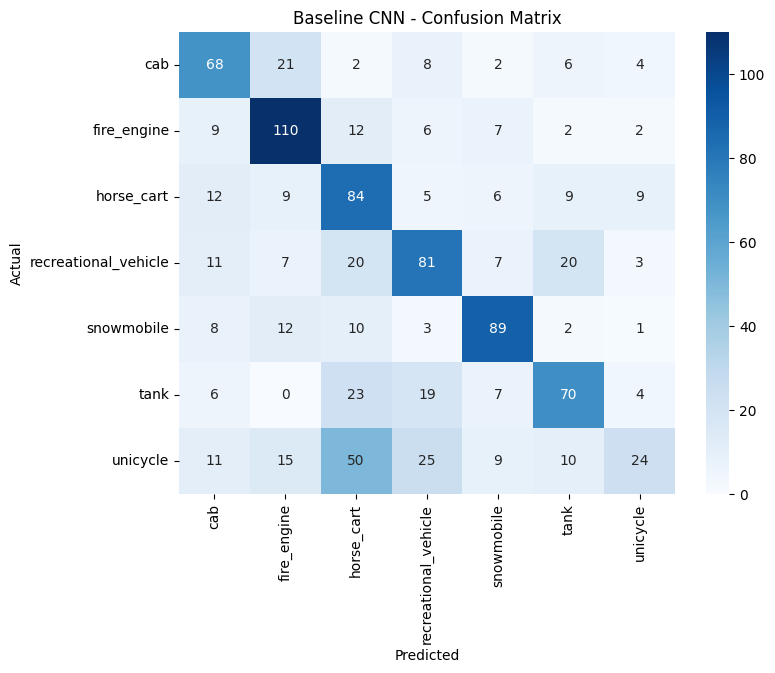


Evaluating Deeper CNN (Adam)
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.7296 - loss: 0.7812
Deeper CNN (Adam) - Test Accuracy: 68.62%
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step
                      precision    recall  f1-score   support

                 cab       0.62      0.72      0.67       111
         fire_engine       0.63      0.84      0.72       148
          horse_cart       0.67      0.64      0.66       134
recreational_vehicle       0.72      0.68      0.70       149
          snowmobile       0.84      0.69      0.76       125
                tank       0.72      0.77      0.74       129
            unicycle       0.65      0.47      0.55       144

            accuracy                           0.69       940
           macro avg       0.69      0.69      0.68       940
        weighted avg       0.69      0.69      0.68       940



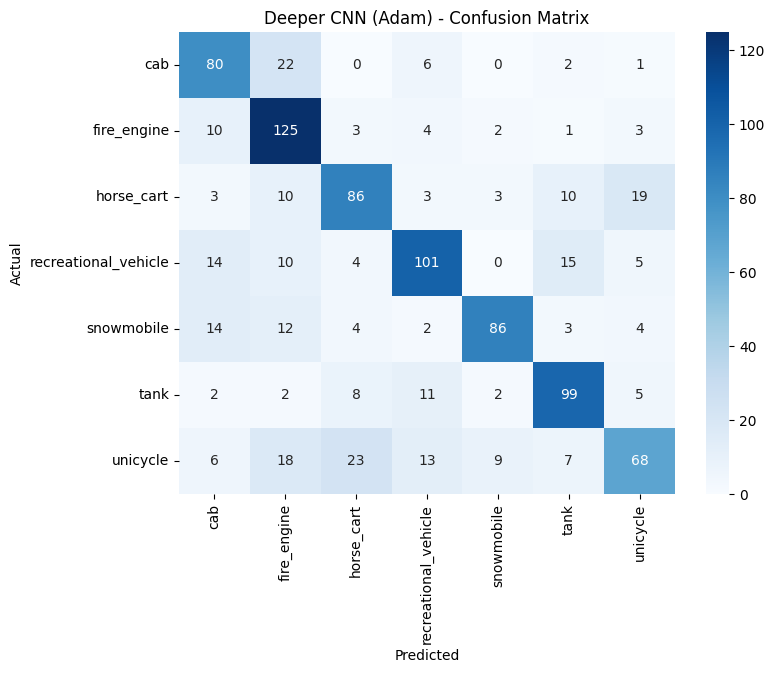


Evaluating Deeper CNN (SGD)
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.6956 - loss: 0.9030
Deeper CNN (SGD) - Test Accuracy: 63.09%
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step
                      precision    recall  f1-score   support

                 cab       0.63      0.69      0.66       111
         fire_engine       0.63      0.79      0.70       148
          horse_cart       0.52      0.68      0.59       134
recreational_vehicle       0.66      0.55      0.60       149
          snowmobile       0.79      0.74      0.77       125
                tank       0.61      0.67      0.64       129
            unicycle       0.66      0.32      0.43       144

            accuracy                           0.63       940
           macro avg       0.64      0.64      0.63       940
        weighted avg       0.64      0.63      0.62       940



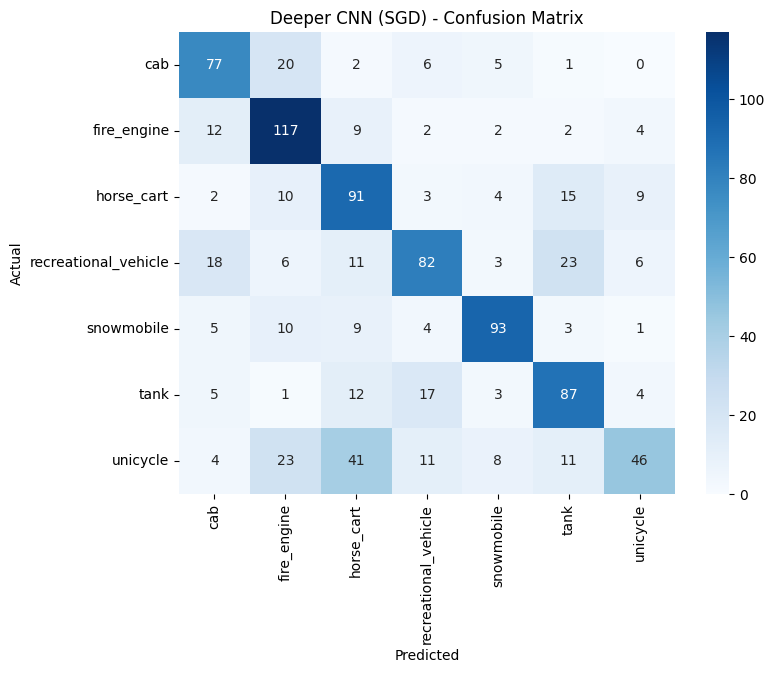

In [18]:
# Unified Evaluation Function for All Models

def evaluate_model(model, name):
    print(f"\nEvaluating {name}")
    loss, acc = model.evaluate(test_generator)
    print(f'{name} - Test Accuracy: {acc * 100:.2f}%')

    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


evaluate_model(baseline_model, "Baseline CNN")
evaluate_model(deep_model_adam, "Deeper CNN (Adam)")
evaluate_model(deep_model_sgd, "Deeper CNN (SGD)")

# Step 9: plotting Training Histories for Comparison

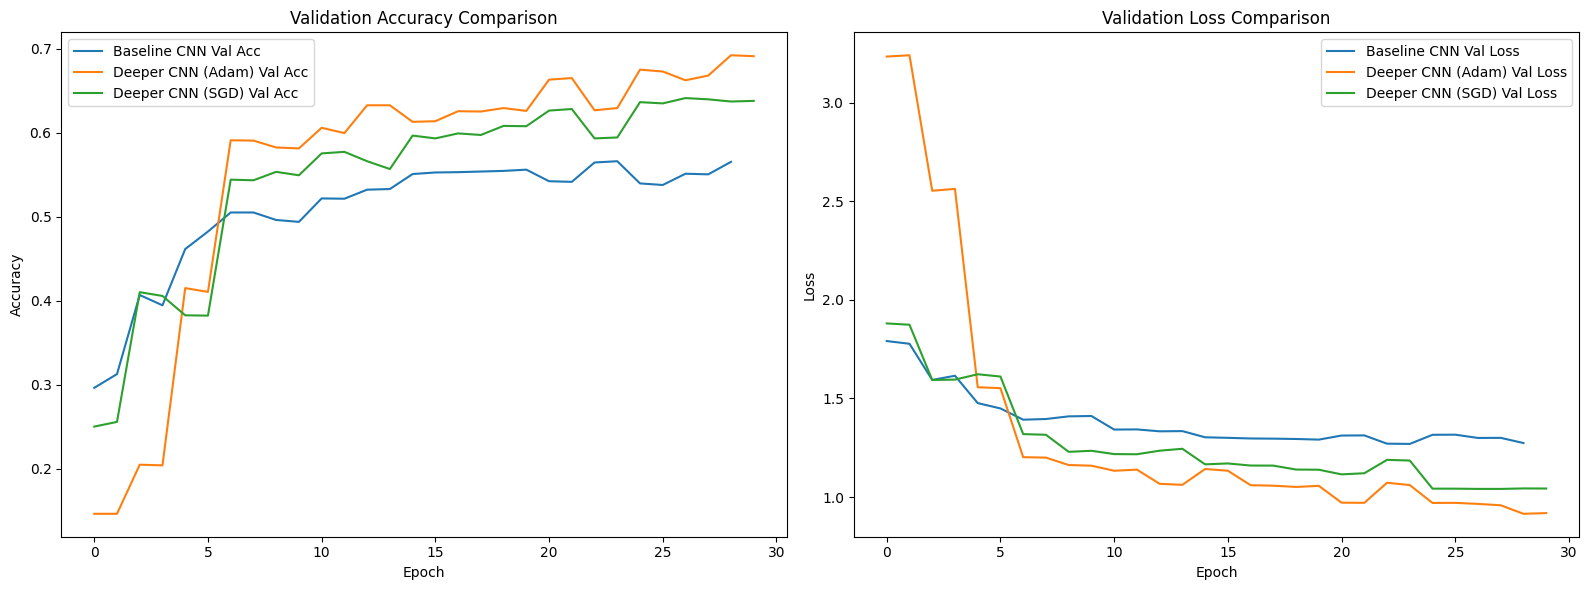

In [19]:
# Plot Accuracy and Loss Curves for Visual Comparison

def plot_all_histories(histories, labels):
    plt.figure(figsize=(16, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_all_histories(
    [history_baseline, history_deep_adam, history_deep_sgd],
    ['Baseline CNN', 'Deeper CNN (Adam)', 'Deeper CNN (SGD)']
)


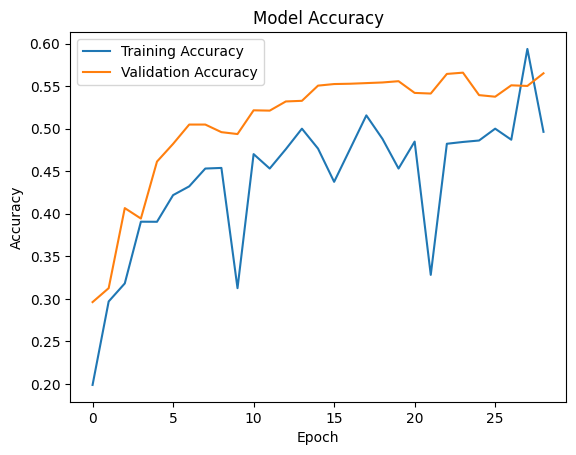

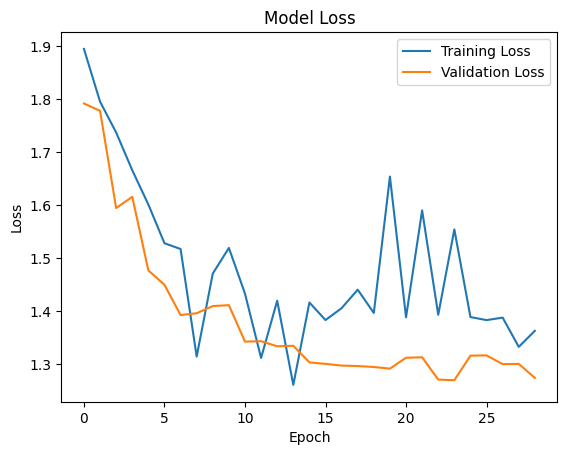

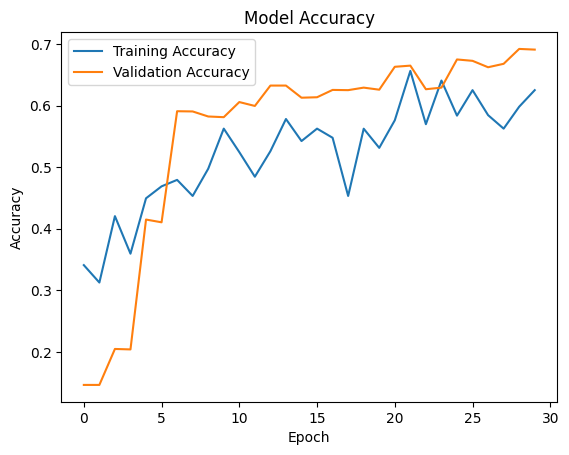

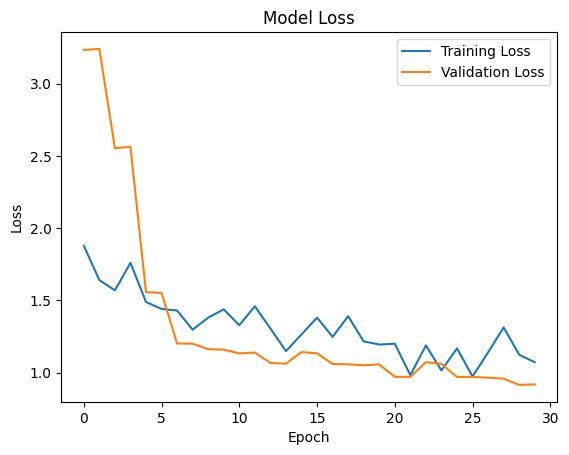

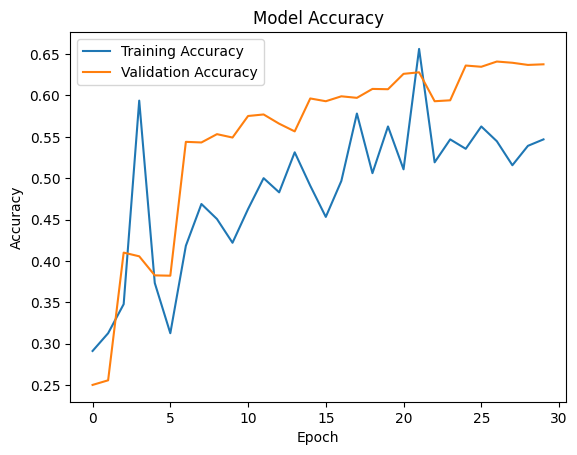

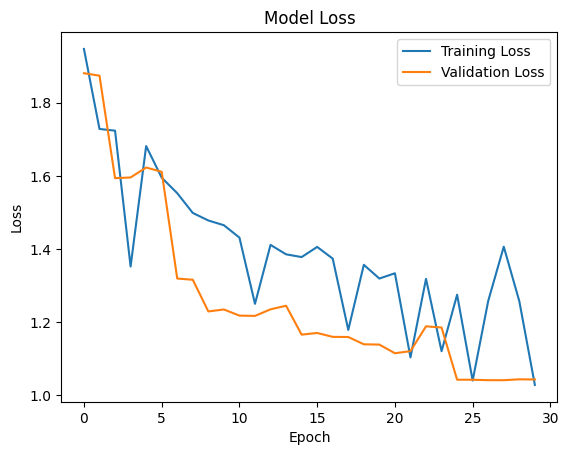

In [20]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_baseline)
plot_history(history_deep_adam)
plot_history(history_deep_sgd)

# Step 9: Generate Confusion Matrix


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step


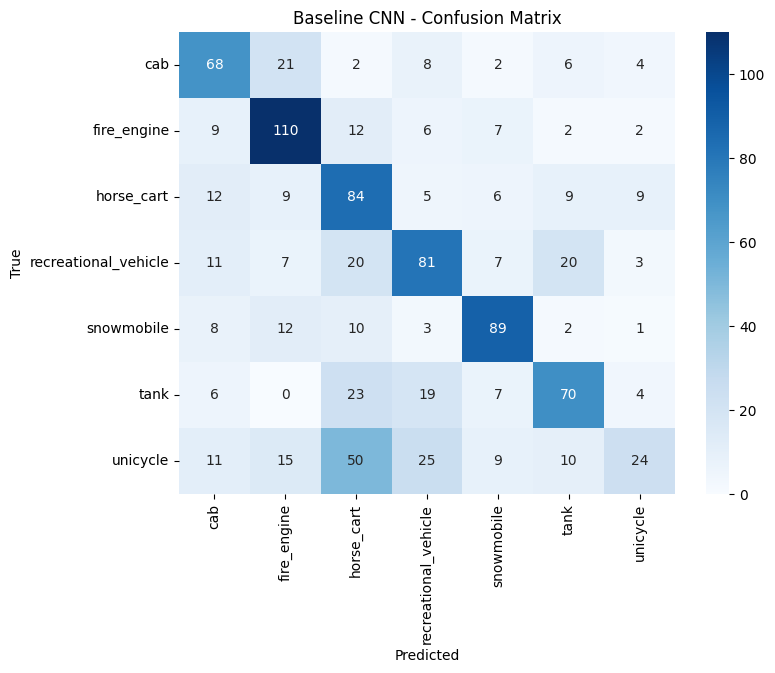

Baseline CNN - Classification Report:
                      precision    recall  f1-score   support

                 cab       0.54      0.61      0.58       111
         fire_engine       0.63      0.74      0.68       148
          horse_cart       0.42      0.63      0.50       134
recreational_vehicle       0.55      0.54      0.55       149
          snowmobile       0.70      0.71      0.71       125
                tank       0.59      0.54      0.56       129
            unicycle       0.51      0.17      0.25       144

            accuracy                           0.56       940
           macro avg       0.56      0.56      0.55       940
        weighted avg       0.56      0.56      0.54       940

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step


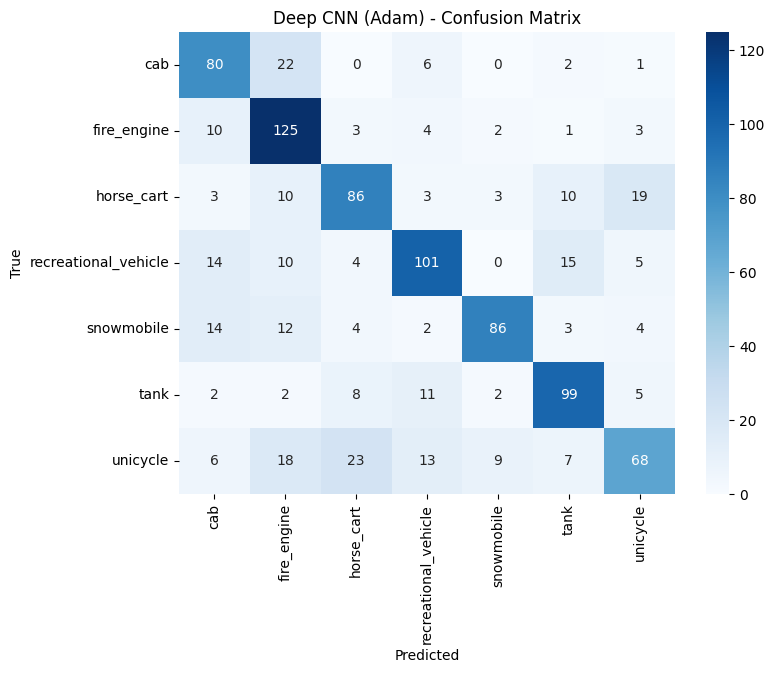

Deep CNN (Adam) - Classification Report:
                      precision    recall  f1-score   support

                 cab       0.62      0.72      0.67       111
         fire_engine       0.63      0.84      0.72       148
          horse_cart       0.67      0.64      0.66       134
recreational_vehicle       0.72      0.68      0.70       149
          snowmobile       0.84      0.69      0.76       125
                tank       0.72      0.77      0.74       129
            unicycle       0.65      0.47      0.55       144

            accuracy                           0.69       940
           macro avg       0.69      0.69      0.68       940
        weighted avg       0.69      0.69      0.68       940

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step


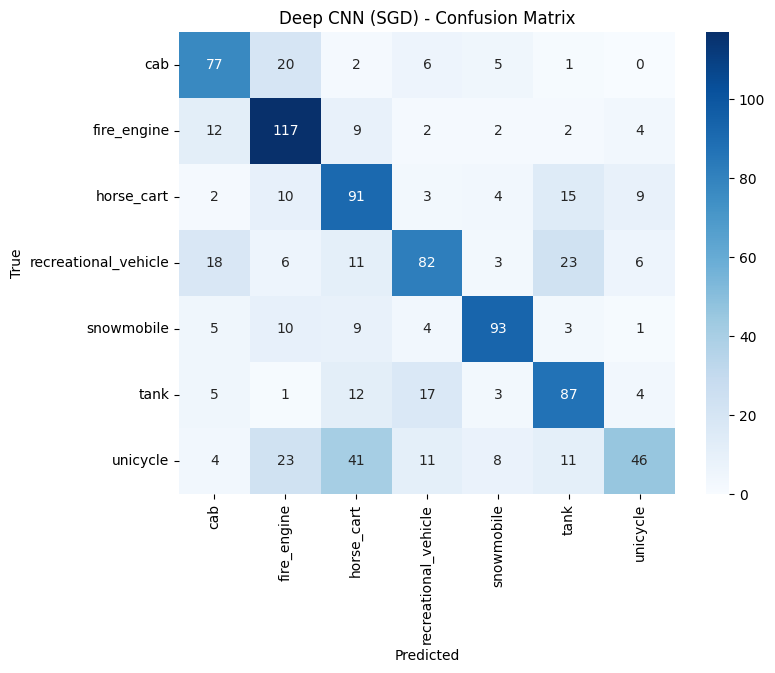

Deep CNN (SGD) - Classification Report:
                      precision    recall  f1-score   support

                 cab       0.63      0.69      0.66       111
         fire_engine       0.63      0.79      0.70       148
          horse_cart       0.52      0.68      0.59       134
recreational_vehicle       0.66      0.55      0.60       149
          snowmobile       0.79      0.74      0.77       125
                tank       0.61      0.67      0.64       129
            unicycle       0.66      0.32      0.43       144

            accuracy                           0.63       940
           macro avg       0.64      0.64      0.63       940
        weighted avg       0.64      0.63      0.62       940



In [22]:
# Get predictions
def evaluate_model_matrix(model, test_generator, class_names, title="Model"):
    y_pred_probs = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(f"{title} - Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

class_names = list(test_generator.class_indices.keys())

evaluate_model_matrix(baseline_model, test_generator, class_names, title="Baseline CNN")
evaluate_model_matrix(deep_model_adam, test_generator, class_names, title="Deep CNN (Adam)")
evaluate_model_matrix(deep_model_sgd, test_generator, class_names, title="Deep CNN (SGD)")

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step


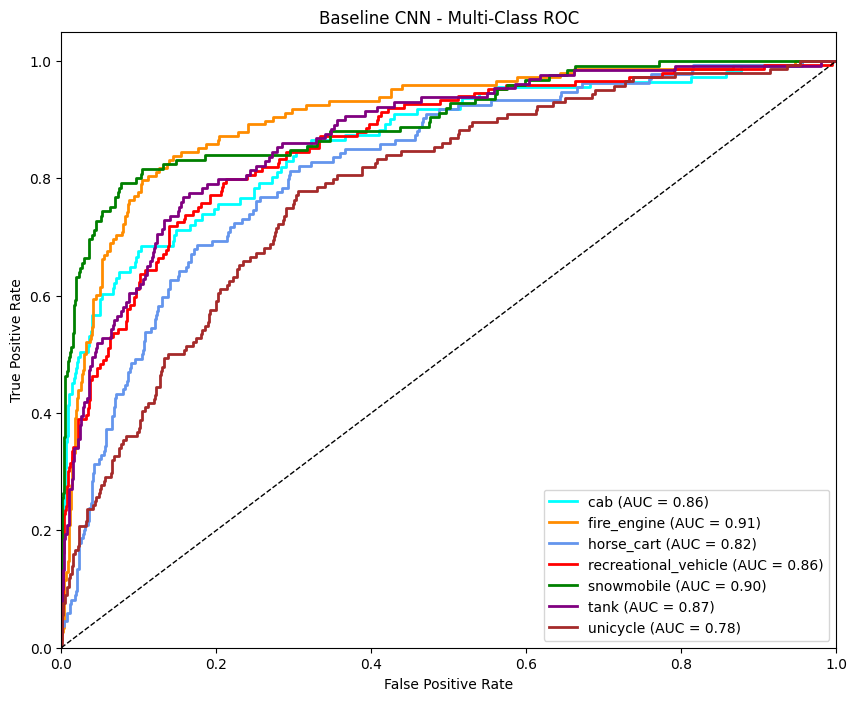

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step


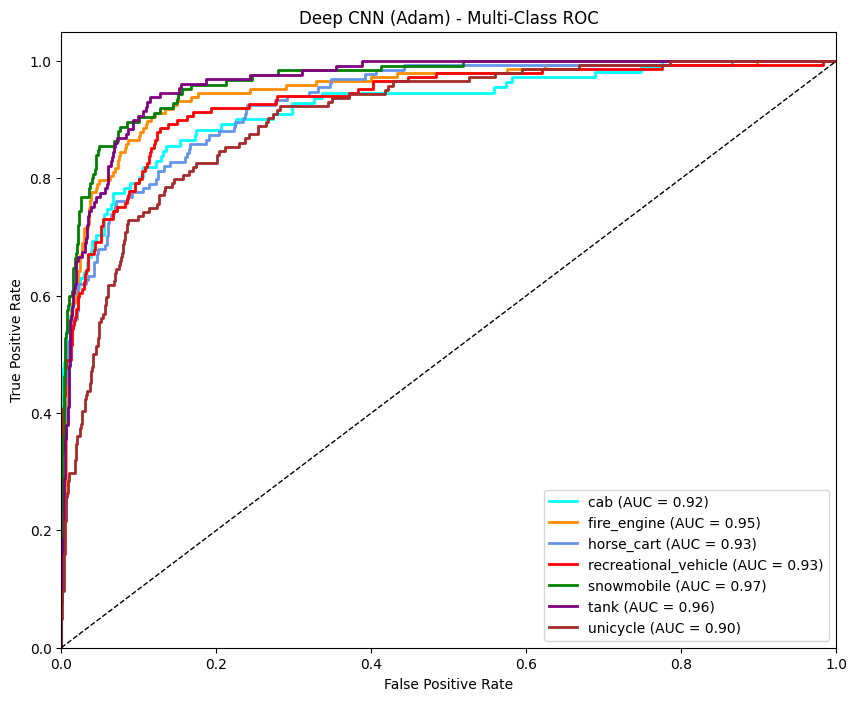

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step


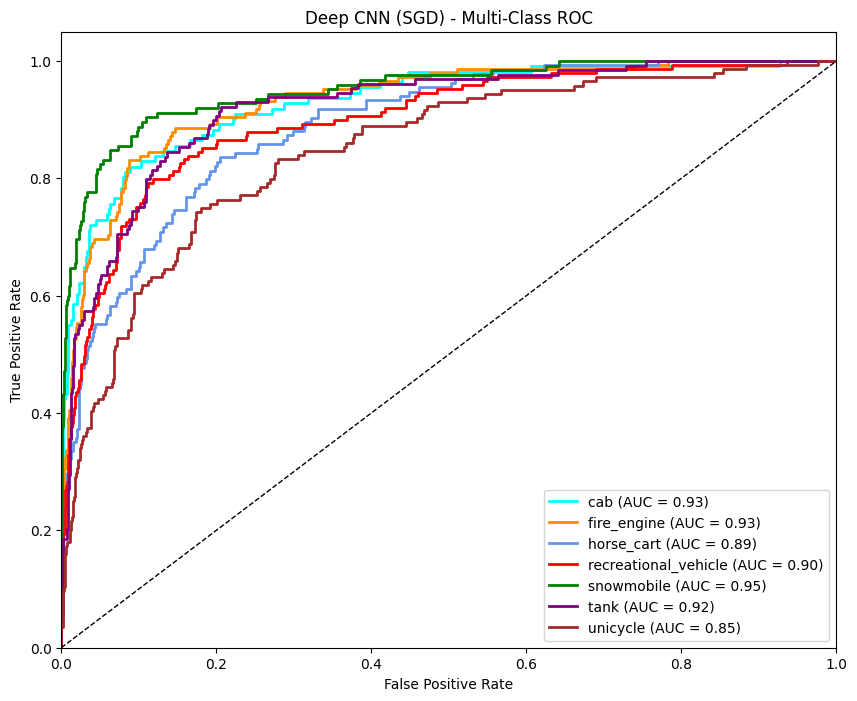

In [23]:
from sklearn.preprocessing import label_binarize
from itertools import cycle


def plot_multiclass_roc(model, test_generator, class_names, title='ROC Curve'):
    # Ground truth and predicted probabilities
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)

    # Binarize the output
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - Multi-Class ROC')
    plt.legend(loc='lower right')
    plt.show()


plot_multiclass_roc(baseline_model, test_generator, class_names, title="Baseline CNN")
plot_multiclass_roc(deep_model_adam, test_generator, class_names, title="Deep CNN (Adam)")
plot_multiclass_roc(deep_model_sgd, test_generator, class_names, title="Deep CNN (SGD)")

# Part B: Transfer Learning with MobileNetV2

# Step 1: Adjust Data Generators for Transfer Learning

In [24]:
# -----------------------------------------------
# Part B: Transfer Learning - Data Preparation
# Using 128x128 since MobileNetV2 supports it
# -----------------------------------------------

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Re-define generators for MobileNetV2
train_tl_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Updated Generators
train_tl_generator = train_tl_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_tl_generator = val_tl_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_tl_generator = test_tl_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8688 images belonging to 7 classes.
Found 2702 images belonging to 7 classes.
Found 940 images belonging to 7 classes.


# Step 2: Load and Customize Pretrained MobileNetV2

In [26]:
# ---------------------------------------------------
# Load MobileNetV2 and add custom classification head
# ---------------------------------------------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def create_transfer_model():
    base_model = MobileNetV2(include_top=False,
                             input_shape=(128, 128, 3),
                             weights='imagenet')

    # Freeze base model for feature extraction
    base_model.trainable = False

    # Add new top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_OF_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

transfer_model = create_transfer_model()
transfer_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 3: Train (Feature Extraction Phase)

In [27]:
# ------------------------------------
# Train Only the Custom Classification Head
# ------------------------------------
history_transfer = train_model(transfer_model, 'transfer_model_mobilenetv2')



Using class weights: {0: np.float64(1.5494917067950775), 1: np.float64(0.9310899153359768), 2: np.float64(0.9569335829937218), 3: np.float64(0.9795918367346939), 4: np.float64(0.9186845722745056), 5: np.float64(0.926226012793177), 6: np.float64(0.9554602441438469)}
Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.2664 - loss: 2.0910 - val_accuracy: 0.8646 - val_loss: 0.6795 - learning_rate: 1.0000e-04
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 1:27 654ms/step - accuracy: 0.5781 - loss: 1.2742

/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.5781 - loss: 1.2742 - val_accuracy: 0.8664 - val_loss: 0.6744 - learning_rate: 1.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5846 - loss: 1.1662 - val_accuracy: 0.9193 - val_loss: 0.3471 - learning_rate: 1.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step - accuracy: 0.6250 - loss: 1.0112 - val_accuracy: 0.9204 - val_loss: 0.3462 - learning_rate: 1.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6543 - loss: 0.9793 - val_accuracy: 0.9245 - val_loss: 0.2726 - learning_rate: 1.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.6875 - loss: 0.8980 - val_accuracy: 0.9241 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.6956 - loss: 0.8556 - val_accuracy: 0.9293 - val_loss: 0.2386 - learning_rate: 1.0000e-04
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accura


Training completed in 55.94 minutes


# Step 4: Fine-Tune Model

In [29]:
# ------------------------------------------
# Unfreeze Top Layers and Fine-Tune Model
# ------------------------------------------
# Unfreeze last 20 layers
for layer in transfer_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):  # Skip BatchNorm for stability
        layer.trainable = True

transfer_model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Fine-tune the model
history_finetuned = train_model(transfer_model, 'transfer_model_finetuned')



Using class weights: {0: np.float64(1.5494917067950775), 1: np.float64(0.9310899153359768), 2: np.float64(0.9569335829937218), 3: np.float64(0.9795918367346939), 4: np.float64(0.9186845722745056), 5: np.float64(0.926226012793177), 6: np.float64(0.9554602441438469)}
Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7849 - loss: 0.6063 - val_accuracy: 0.9420 - val_loss: 0.1800 - learning_rate: 1.0000e-05
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 1:32 687ms/step - accuracy: 0.7656 - loss: 0.8178

/media/samyog/My Folder/AI and ML/AI-and-ML/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.7656 - loss: 0.8178 - val_accuracy: 0.9408 - val_loss: 0.1795 - learning_rate: 1.0000e-05
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7889 - loss: 0.5923 - val_accuracy: 0.9390 - val_loss: 0.1827 - learning_rate: 1.0000e-05
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.7344 - loss: 0.6888 - val_accuracy: 0.9382 - val_loss: 0.1828 - learning_rate: 1.0000e-05
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7990 - loss: 0.5640 - val_accuracy: 0.9405 - val_loss: 0.1859 - learning_rate: 1.0000e-05
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.8594 - loss: 0.4067 - val_accuracy: 0.9408 - val_loss: 0.1854 - learning_rate: 1.0000e-05
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8000 - loss: 0.5743 - val_accuracy: 0.9401 - val_loss: 0.1800 - learning_rate: 1.0000e-05



Training completed in 11.37 minutes


# Step 5: Evaluate Transfer Learning Models


Evaluating Transfer Learning Model (MobileNetV2)
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 757ms/step - accuracy: 0.9445 - loss: 0.1666
Transfer Learning Model (MobileNetV2) - Test Accuracy: 95.32%
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 884ms/step
                      precision    recall  f1-score   support

                 cab       0.90      0.94      0.92       111
         fire_engine       0.93      0.94      0.94       148
          horse_cart       0.98      0.95      0.97       134
recreational_vehicle       0.97      0.98      0.97       149
          snowmobile       0.99      0.94      0.96       125
                tank       0.96      0.97      0.97       129
            unicycle       0.94      0.96      0.95       144

            accuracy                           0.95       940
           macro avg       0.95      0.95      0.95       940
        weighted avg       0.95      0.95      0.95       940



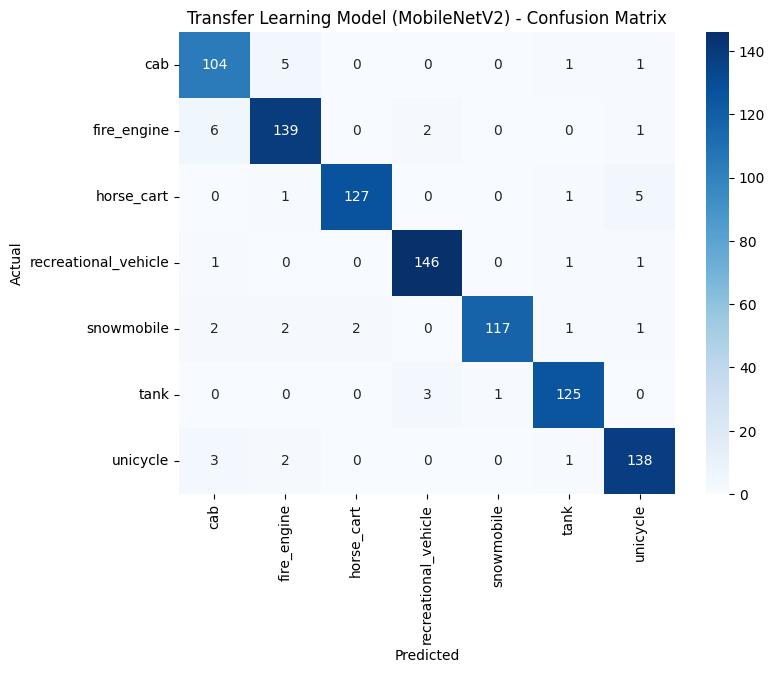

In [30]:
evaluate_model(transfer_model, "Transfer Learning Model (MobileNetV2)")

# Step 6: Plot History

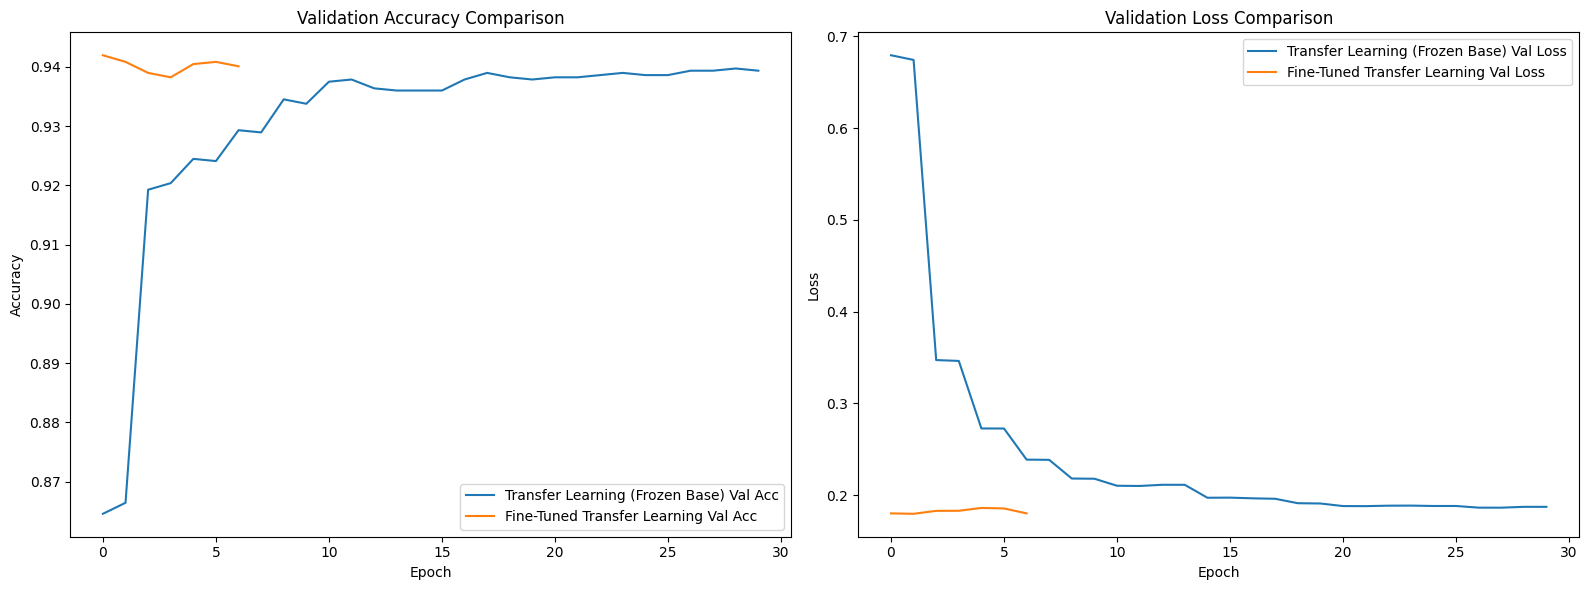

In [31]:
# Plot fine-tuned and original transfer learning performance
plot_all_histories(
    [history_transfer, history_finetuned],
    ['Transfer Learning (Frozen Base)', 'Fine-Tuned Transfer Learning']
)


Classes found: ['cab', 'fire_engine', 'horse_cart', 'recreational_vehicle', 'snowmobile', 'tank', 'unicycle']


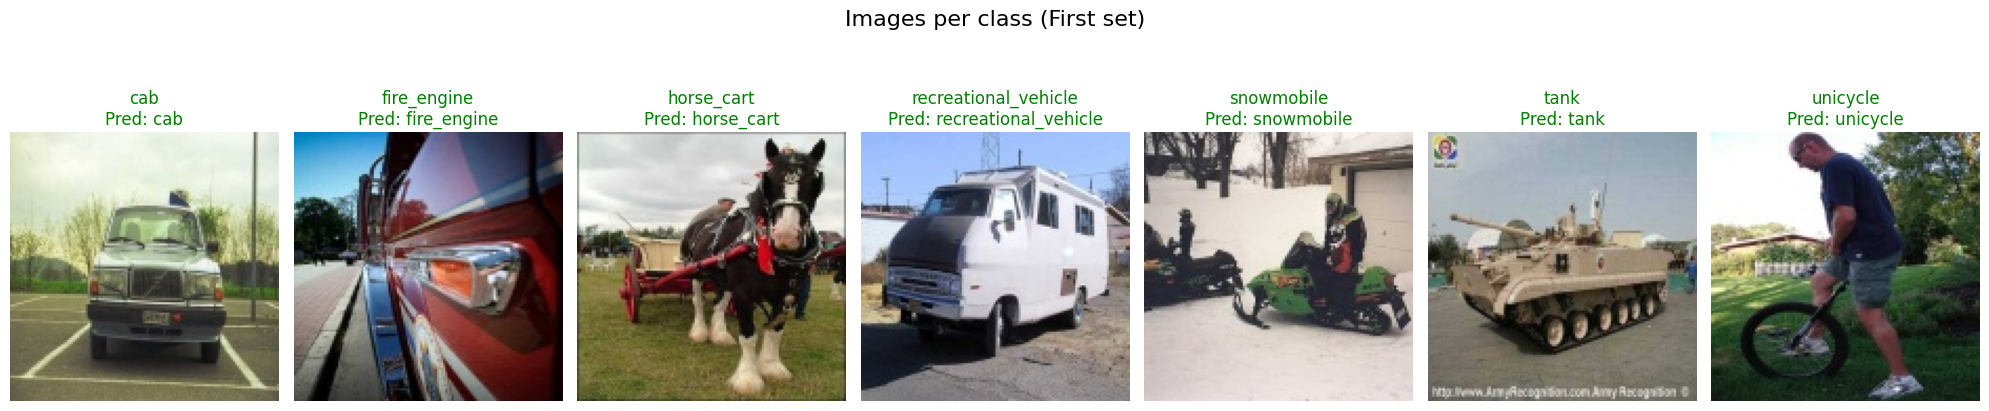

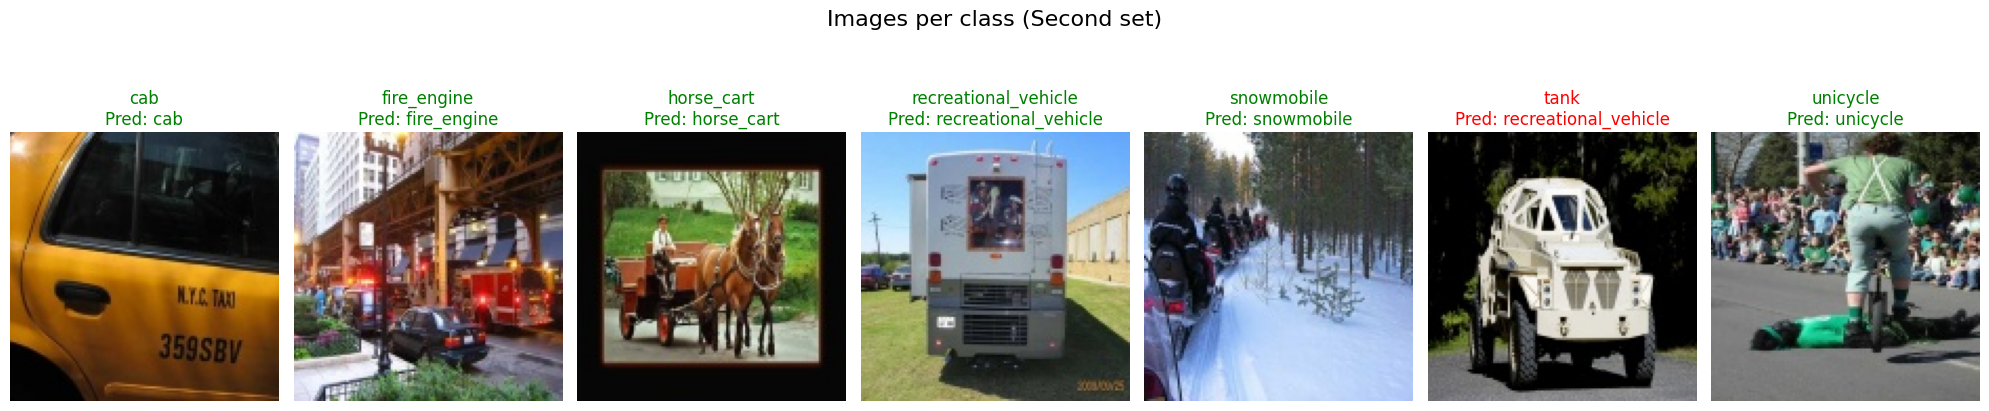

In [10]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
# model = load_model('baseline_cnn.h5')
# model = load_model('deep_cnn_adam.h5')
# model = load_model('deep_cnn_sgd.h5')
# model = load_model('transfer_model_mobilenetv2.h5')
model = load_model('transfer_model_finetuned.h5')


# Dataset path
dataset_path = '/media/samyog/My Folder/AI and ML/Others/Vehicles/test'

# Get sorted class folders
class_folders = sorted(os.listdir(dataset_path))
print("Classes found:", class_folders)

# Function to display 1 image per class, at a given index in each class folder
def display_images(image_index=0, title_suffix=""):
    fig, axes = plt.subplots(1, len(class_folders), figsize=(20, 5))
    for idx, class_name in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_name)
        image_files = sorted(os.listdir(class_path))  # Sort for consistent ordering

        if len(image_files) > image_index:
            img_path = os.path.join(class_path, image_files[image_index])
            img = image.load_img(img_path, target_size=(128, 128))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            prediction = model.predict(img_array, verbose=0)
            predicted_class = class_folders[np.argmax(prediction)]

            # Determine title color based on correctness
            title_color = 'green' if predicted_class == class_name else 'red'

            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f"{class_name}\nPred: {predicted_class}", color=title_color)
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f"{class_name}\nNo image {image_index}")
    plt.suptitle(f"Images per class {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Display image 0 and image 1 per class
display_images(image_index=0, title_suffix="(First set)")
display_images(image_index=1, title_suffix="(Second set)")
